In [1]:
# Step 1: Install dependencies
!pip install --quiet scikit-learn pandas matplotlib seaborn torch torchvision

# Step 2: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# Seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Step 3: Load NSL-KDD data from online source
# Download NSL-KDD train and test data from GitHub mirror
train_url = 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt'
test_url = 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt'

cols = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label", "difficulty"
]

train_df = pd.read_csv(train_url, names=cols)
test_df = pd.read_csv(test_url, names=cols)

print(f"Train data shape: {train_df.shape}, Test data shape: {test_df.shape}")

Train data shape: (125973, 43), Test data shape: (22544, 43)


In [3]:
# Step 4: Preprocessing - simplify labels and encode categorical features
train_df['binary_label'] = train_df['label'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['binary_label'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

cat_cols = ['protocol_type', 'service', 'flag']
for c in cat_cols:
    le = LabelEncoder()
    train_df[c] = le.fit_transform(train_df[c])
    test_df[c] = le.transform(test_df[c])

# Drop unused columns
drop_cols = ['label', 'difficulty']
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

print("Sample preprocessed train data:")
train_df.head()

Sample preprocessed train data:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,binary_label
0,0,1,20,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [4]:
# Step 5: Split features and labels
X_train = train_df.drop(columns=['binary_label'])
y_train = train_df['binary_label']

X_test = test_df.drop(columns=['binary_label'])
y_test = test_df['binary_label']

# Normalize continuous features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (125973, 41), X_test shape: (22544, 41)


In [5]:
# Step 6: Prepare PyTorch dataset focusing on minority class (attacks)
attack_idx = np.where(y_train == 1)[0]
X_attack = torch.tensor(X_train[attack_idx], dtype=torch.float32)

batch_size = 128
attack_loader = DataLoader(TensorDataset(X_attack), batch_size=batch_size, shuffle=True)

In [6]:
# Step 7: Define VAE model for tabular data
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc21 = nn.Linear(64, latent_dim)  # mean
        self.fc22 = nn.Linear(64, latent_dim)  # logvar
        self.fc3 = nn.Linear(latent_dim, 64)
        self.fc4 = nn.Linear(64, input_dim)
        self.relu = nn.ReLU()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [7]:
# Step 8: Train VAE on minority class data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = X_train.shape[1]
latent_dim = 10

vae = VAE(input_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 30
vae.train()

for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data,) in enumerate(attack_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(attack_loader.dataset):.4f}")

Using device: cpu
Epoch 1, Loss: 24.7796
Epoch 2, Loss: 18.1484
Epoch 3, Loss: 16.1947
Epoch 4, Loss: 14.9895
Epoch 5, Loss: 13.6706
Epoch 6, Loss: 12.6812
Epoch 7, Loss: 11.7710
Epoch 8, Loss: 11.3560
Epoch 9, Loss: 10.5793
Epoch 10, Loss: 10.0932
Epoch 11, Loss: 9.9901
Epoch 12, Loss: 9.7221
Epoch 13, Loss: 9.6606
Epoch 14, Loss: 9.3723
Epoch 15, Loss: 9.7029
Epoch 16, Loss: 16.3617
Epoch 17, Loss: 9.7621
Epoch 18, Loss: 9.0338
Epoch 19, Loss: 8.9111
Epoch 20, Loss: 8.8867
Epoch 21, Loss: 8.8137
Epoch 22, Loss: 8.5484
Epoch 23, Loss: 8.5187
Epoch 24, Loss: 8.4716
Epoch 25, Loss: 8.3925
Epoch 26, Loss: 8.2742
Epoch 27, Loss: 8.1577
Epoch 28, Loss: 8.3189
Epoch 29, Loss: 8.1927
Epoch 30, Loss: 7.9276


In [8]:
# Step 9: Generate synthetic attack data with VAE
vae.eval()
with torch.no_grad():
    z = torch.randn(5000, latent_dim).to(device)
    generated = vae.decode(z).cpu().numpy()

print(f"Synthetic attack samples shape: {generated.shape}")

Synthetic attack samples shape: (5000, 41)


In [9]:
# Step 10: Combine real normal data + synthetic attack data for training classifier
normal_idx = np.where(y_train == 0)[0]
X_normal = X_train[normal_idx]

X_aug = np.vstack([X_normal, generated])
y_aug = np.hstack([np.zeros(len(X_normal)), np.ones(len(generated))])

print(f"Augmented data shape: {X_aug.shape}, Augmented labels shape: {y_aug.shape}")

Augmented data shape: (72343, 41), Augmented labels shape: (72343,)


In [10]:
# Step 11: Train Random Forest classifier on augmented data and evaluate
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=SEED)
clf.fit(X_aug, y_aug)
y_pred = clf.predict(X_test)

print("Classification report on test data:")
print(classification_report(y_test, y_pred))

Classification report on test data:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60      9711
           1       0.00      0.00      0.00     12833

    accuracy                           0.43     22544
   macro avg       0.22      0.50      0.30     22544
weighted avg       0.19      0.43      0.26     22544



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


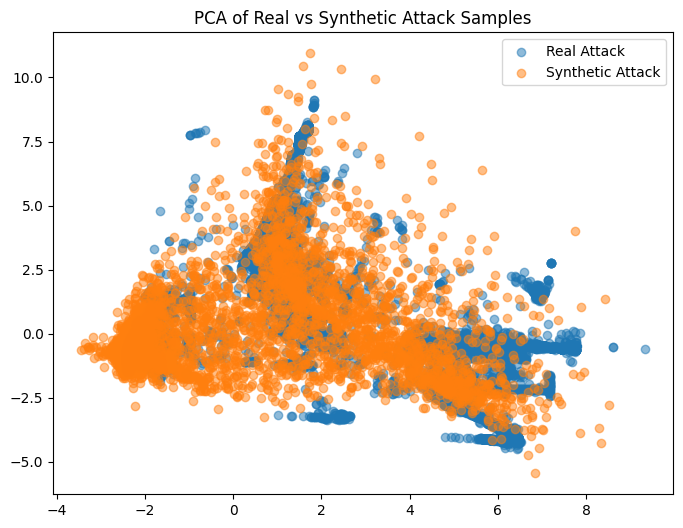

In [11]:
# Step 12: Visualize synthetic vs real attack distribution (PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
real_attack_2d = pca.fit_transform(X_attack.numpy())
synthetic_attack_2d = pca.transform(generated)

plt.figure(figsize=(8,6))
plt.scatter(real_attack_2d[:,0], real_attack_2d[:,1], alpha=0.5, label='Real Attack')
plt.scatter(synthetic_attack_2d[:,0], synthetic_attack_2d[:,1], alpha=0.5, label='Synthetic Attack')
plt.legend()
plt.title('PCA of Real vs Synthetic Attack Samples')
plt.show()